In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.amp import autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Paths — adjust DATA_ROOT if your dataset lives elsewhere
DATA_ROOT = "dataset"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# Hyperparameters — identical to the original train.py defaults
EPOCHS = 30
BATCH_SIZE = 4 # from 8 to 4
LR = 1e-4
IMG_SIZE = 512 # from 256 to 512
NUM_WORKERS = 0

In [3]:
# Original class IDs found in the masks -> contiguous labels [0-9]
CLASS_IDS = [100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]
NUM_CLASSES = len(CLASS_IDS)

# Build a lookup table for fast remapping (max value is 10000, so table size is 10001)
_REMAP_LUT = np.full(10001, 0, dtype=np.int64)  # default to 0 for any unexpected value
for contiguous_label, original_id in enumerate(CLASS_IDS):
    _REMAP_LUT[original_id] = contiguous_label


def remap_mask(mask: np.ndarray) -> np.ndarray:
    """Remap raw mask pixel values to contiguous class indices [0, NUM_CLASSES-1]."""
    return _REMAP_LUT[mask]


print(f"Classes: {NUM_CLASSES}")
print(f"ID mapping: {dict(zip(CLASS_IDS, range(NUM_CLASSES)))}")

Classes: 10
ID mapping: {100: 0, 200: 1, 300: 2, 500: 3, 550: 4, 600: 5, 700: 6, 800: 7, 7100: 8, 10000: 9}


In [4]:
class SegmentationDataset(Dataset):
    """
    Pairs images and masks by SORTED INDEX, not by filename.
    This is required because filenames differ between the two folders.
    """

    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Sort both lists independently — alignment is by index
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        assert len(self.images) == len(self.masks), (
            f"Mismatch: {len(self.images)} images vs {len(self.masks)} masks"
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image as RGB (OpenCV loads BGR by default)
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as uint16 grayscale — critical for values > 255 like 7100, 10000
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # If mask was loaded as 3-channel, take first channel
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Remap to contiguous class IDs [0-9]
        mask = remap_mask(mask).astype(np.int64)

        # Apply augmentations — Albumentations treats mask as integer labels automatically
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]           # float32 tensor [3, H, W]
            mask = augmented["mask"]             # int64 tensor [H, W]

        # Ensure mask is LongTensor for CrossEntropyLoss / segmentation losses
        mask = mask.long() if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).long()

        return image, mask

In [5]:
def get_val_transforms(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [6]:
def build_model():
    model = smp.DeepLabV3Plus(
        encoder_name="resnet50",    # efficientnetB0 to resnet50    
        encoder_weights="ssl",      # Swapped from 'imagenet' to 'ssl' (Self-Supervised Learning)
        in_channels=3,
        classes=NUM_CLASSES,              
        encoder_output_stride=16,                                
    )
    return model

model = build_model().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model parameters: 26,679,898


In [7]:
print(SegmentationDataset)
print(NUM_CLASSES)
print(CLASS_IDS)
print(next(model.parameters()).device)


<class '__main__.SegmentationDataset'>
10
[100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]
cuda:0


In [11]:
from torch.utils.data import DataLoader

TEST_DATA_ROOT = "testing_dataset"

test_image_dir = f"{TEST_DATA_ROOT}/Color_Images"
test_mask_dir  = f"{TEST_DATA_ROOT}/Segmentation"
val_transform = get_val_transforms(IMG_SIZE)

test_dataset = SegmentationDataset(
    image_dir=test_image_dir,
    mask_dir=test_mask_dir,
    transform=val_transform  # IMPORTANT: deterministic, no augmentation
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,      # safest in notebooks
    pin_memory=True
)

print(f"Loaded TEST dataset with {len(test_dataset)} samples")


Loaded TEST dataset with 1002 samples


In [12]:
checkpoint_path = "checkpoints/best_model.pth"

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

print(f"Loaded best model from: {checkpoint_path}")


Loaded best model from: checkpoints/best_model.pth


In [13]:
import numpy as np
from tqdm import tqdm

def compute_iou(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)

        intersection = np.logical_and(pred_mask, target_mask).sum()
        union = np.logical_or(pred_mask, target_mask).sum()

        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious


all_ious = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating on TEST dataset"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        preds_np = preds.cpu().numpy()
        masks_np = masks.cpu().numpy()

        for p, m in zip(preds_np, masks_np):
            all_ious.append(compute_iou(p, m, NUM_CLASSES))

all_ious = np.array(all_ious)

per_class_iou = np.nanmean(all_ious, axis=0)
mean_iou = np.nanmean(per_class_iou)

print("\nTEST DATASET RESULTS")
print("-" * 45)
for idx, iou in enumerate(per_class_iou):
    print(f"Class {CLASS_IDS[idx]:>5d} (idx {idx}): IoU = {iou:.4f}")
print("-" * 45)
print(f"Overall TEST mIoU: {mean_iou:.4f}")


Evaluating on TEST dataset: 100%|██████████| 251/251 [01:21<00:00,  3.07it/s]


TEST DATASET RESULTS
---------------------------------------------
Class   100 (idx 0): IoU = 0.3307
Class   200 (idx 1): IoU = 0.0023
Class   300 (idx 2): IoU = 0.4524
Class   500 (idx 3): IoU = 0.4119
Class   550 (idx 4): IoU = 0.0000
Class   600 (idx 5): IoU = 0.0000
Class   700 (idx 6): IoU = 0.0000
Class   800 (idx 7): IoU = 0.0356
Class  7100 (idx 8): IoU = 0.6528
Class 10000 (idx 9): IoU = 0.9801
---------------------------------------------
Overall TEST mIoU: 0.2866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].


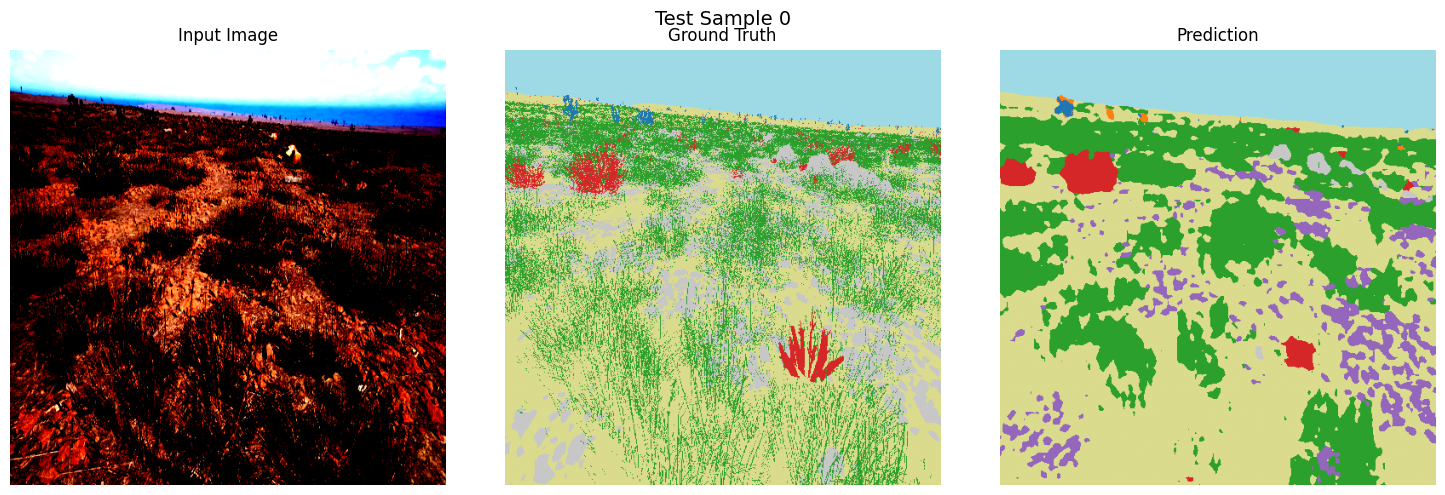

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2216992].


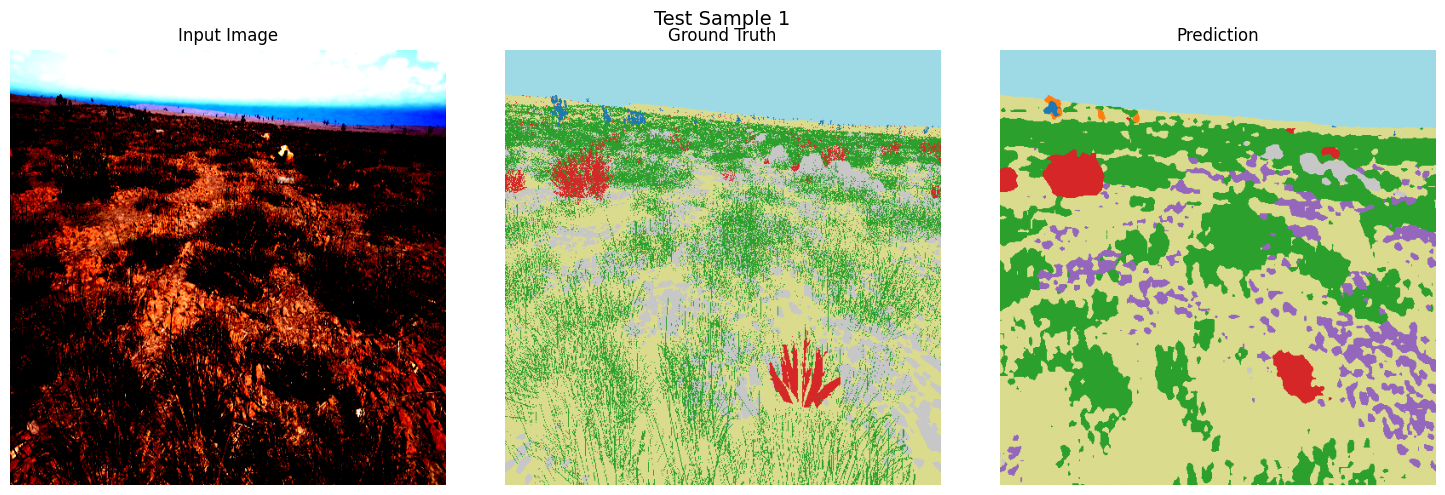

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2216992].


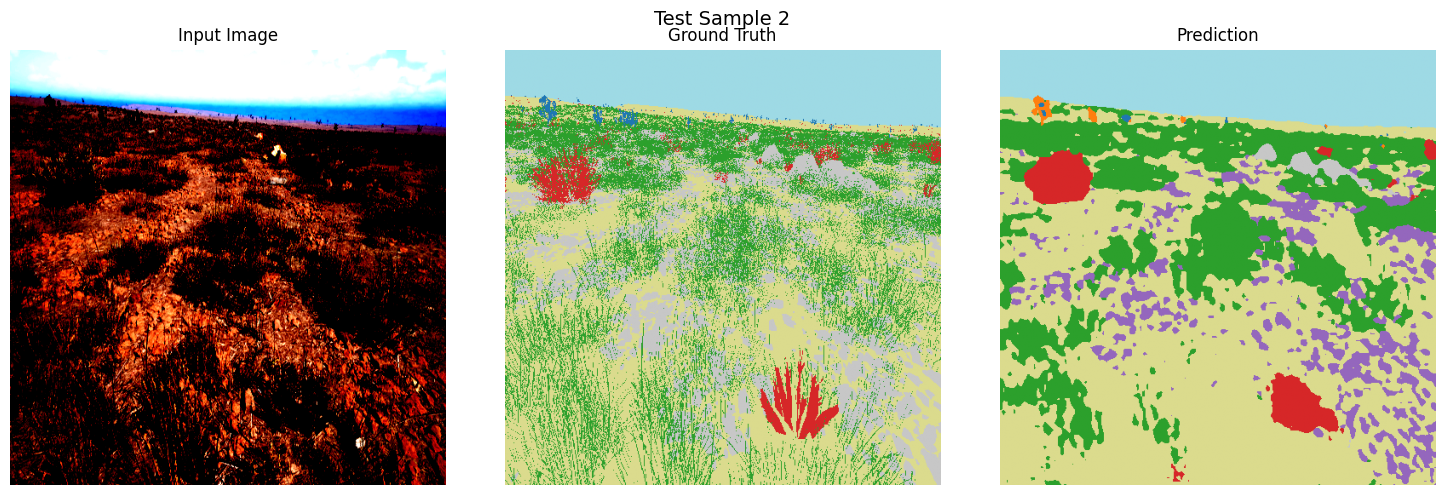

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2216992].


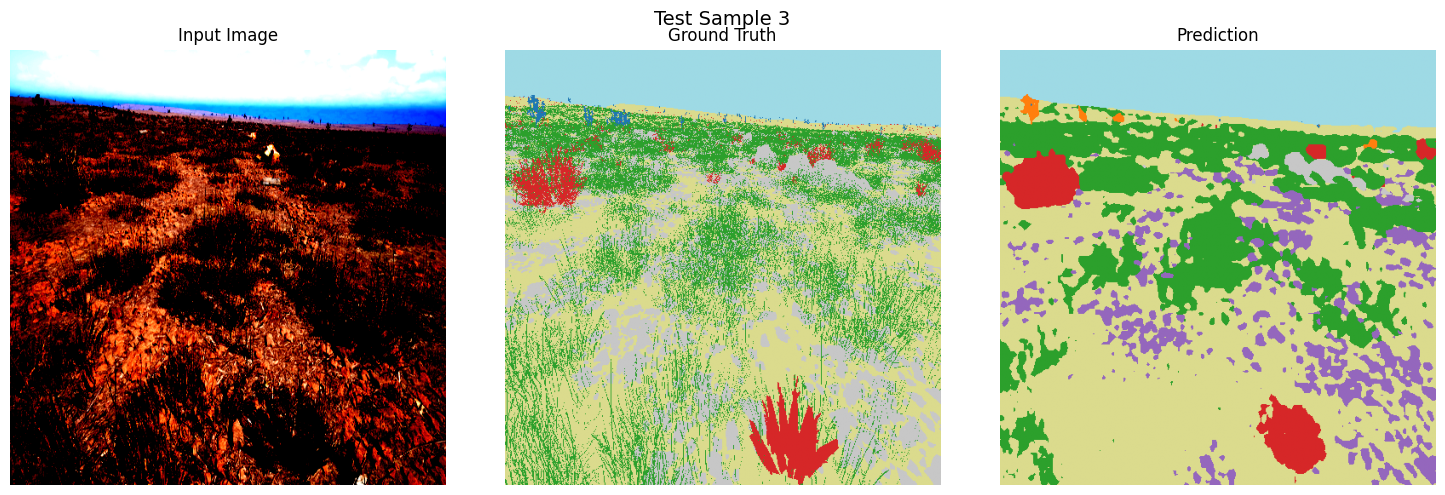

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].


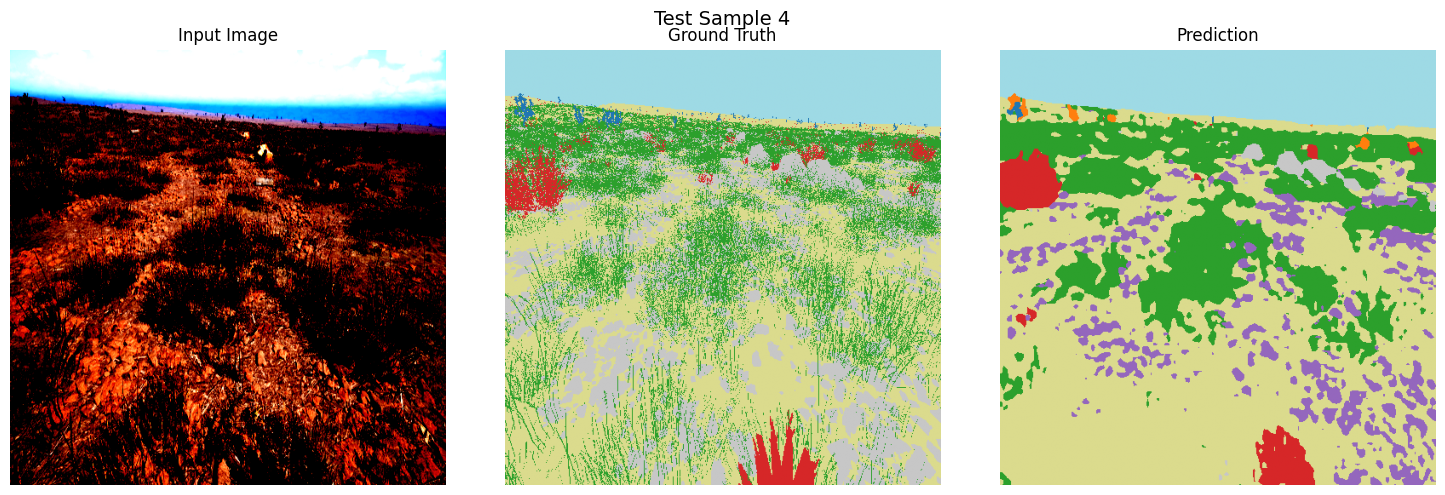

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].


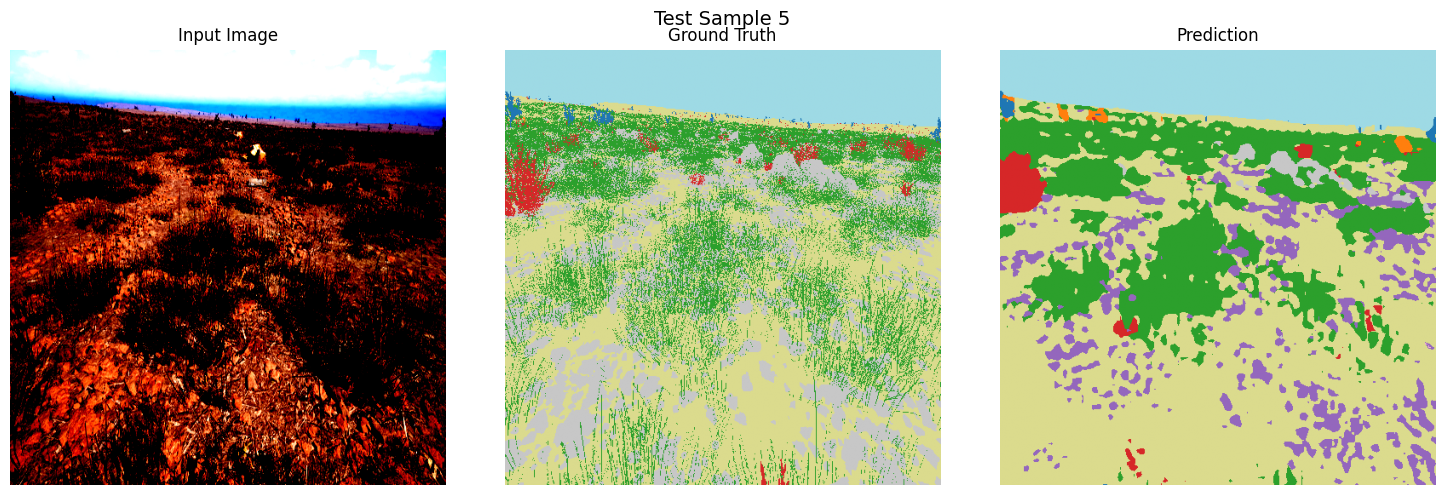

In [14]:
import matplotlib.pyplot as plt

def visualize_sample(image, gt_mask, pred_mask, idx=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(gt_mask, cmap="tab20")
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(pred_mask, cmap="tab20")
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    if idx is not None:
        fig.suptitle(f"Test Sample {idx}", fontsize=14)

    plt.tight_layout()
    plt.show()


# Visualize a few test samples
num_visualize = 6
model.eval()

with torch.no_grad():
    for i in range(num_visualize):
        image, mask = test_dataset[i]

        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        visualize_sample(image_np, mask_np, pred, idx=i)


In [15]:
import os
import cv2

SAVE_TEST_PRED_DIR = "test_predictions"
os.makedirs(SAVE_TEST_PRED_DIR, exist_ok=True)

with torch.no_grad():
    for idx in tqdm(range(len(test_dataset)), desc="Saving test predictions"):
        image, _ = test_dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        save_path = os.path.join(SAVE_TEST_PRED_DIR, f"pred_{idx:04d}.png")
        cv2.imwrite(save_path, pred.astype(np.uint8))

print(f"Saved test predictions to: {SAVE_TEST_PRED_DIR}")


Saving test predictions: 100%|██████████| 1002/1002 [00:56<00:00, 17.69it/s]

Saved test predictions to: test_predictions
